In [1]:
import numpy as np

import random

import networkx as nx

import math
# Affichage graphique

#%matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalgèbreation

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.cm import ScalarMappable

import time

import networkx as nx

from ipywidgets import interact, fixed, FloatSlider
import ipywidgets as widgets

plt.rcParams["figure.figsize"] = [12, 12]

rng = np.random.default_rng(12345)

np.set_printoptions(precision=3)
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)


# <center>R5.A.11 - Méthodes d'optimisation <br> TP2a -- Applications du simplexe</center>


-------------
 <center>      <i> Tom Ferragut, Thibault Godin </i> <br> <i>IUT de Vannes, BUT Informatique </i> </center>



-------------

Le but de ce TP est de proposer plusieurs applications de la méthode du simplexe, en particulier une autre méthode de résolution du problème du flot maximal, vu en R5.A.12 (avec résolution par Edmond-Karp / Ford-Fulferson), en transformant ce problème en un problème d'optimisation linéaire.

In [2]:
from scipy.optimize import linprog, minimize, dual_annealing


## Résolution avec Scipy

La bibliothèque standard pour le calcul scientifique en python est scipy, qui possède une [fonction](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) assez souple et puissante de résolution des problèmes d'optimisation linéaire.

On reprend l'exemple du manuel : 


$$
\begin{aligned}
\min_{x_0, x_1} \quad & -x_0 + 4x_1 \\
\text{sous contraintes} \quad & -3x_0 + x_1 \leq 6, \\
& -x_0 - 2x_1 \geq -4, \\
& x_1 \geq -3.
\end{aligned}
$$

>**_question_**<br>
Représenter (à la main) ce problème en 2d et le résoudre part la méthode graphique (attention aux sens des inéquations et des contraintes. <br>
Mettre ce problème sous forme standard (avec uniquement des $\leq$)

Le problème original est :

$$
\min_{x_0, x_1} \quad -x_0 + 4x_1
$$
avec les contraintes suivantes :

1. $-3x_0 + x_1 \leq 6$
2. $-x_0 - 2x_1 \geq -4$
3. $x_1 \geq -3$

Commençons par transformer la deuxième inégalité ($-x_0 - 2x_1 \geq -4$) en une inégalité de type "≤":

$$
-x_0 - 2x_1 \geq -4 \implies x_0 + 2x_1 \leq 4
$$

La troisième inégalité $x_1 \geq -3$ peut être réécrite comme :

$$
-x_1 \leq 3
$$

Nous obtenons alors les contraintes sous forme standard :

$$
\begin{aligned}
-3x_0 + x_1 &\leq 6, \\
x_0 + 2x_1 &\leq 4, \\
-x_1 &\leq 3.
\end{aligned}
$$


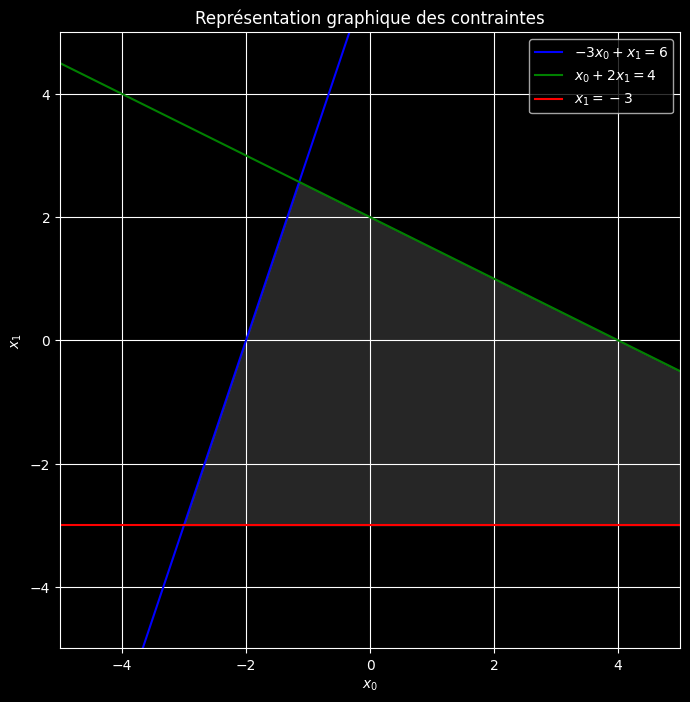

In [3]:
# Creating a range for x0
x0 = np.linspace(-5, 5, 400)

# Defining the lines corresponding to the constraints
constraint1 = (6 + 3 * x0)  # -3x0 + x1 <= 6
constraint2 = (4 - x0) / 2  # x0 + 2x1 <= 4
constraint3 = -3 * np.ones_like(x0)  # x1 >= -3

# Create plot
plt.figure(figsize=(8, 8))

# Plot the constraint lines
plt.plot(x0, constraint1, label=r'$-3x_0 + x_1 = 6$', color='b')
plt.plot(x0, constraint2, label=r'$x_0 + 2x_1 = 4$', color='g')
plt.plot(x0, constraint3, label=r'$x_1 = -3$', color='r')

# Fill the feasible region
plt.fill_between(x0, np.maximum(constraint3, -100), np.minimum(constraint1, constraint2), where=(constraint1 >= constraint3) & (constraint2 >= constraint3), color='grey', alpha=0.3)

# Setting the limits
plt.xlim([-5, 5])
plt.ylim([-5, 5])

# Adding labels and title
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('Représentation graphique des contraintes')

# Adding a legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


Voici la résolution par la bibliothèque Scipy :

In [4]:
c = [-1, 4]

A = [[-3, 1], [1, 2]]

b = [6, 4]

x0_bounds = (None, None)

x1_bounds = (-3, None)

res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])

print(res.fun,res.x)


-22.0 [10. -3.]


>**_question_**<br>
Reprendre les exemples du CM1 avec `scipy`

In [5]:
# 1. Function f(a, b) = a^2 + b^2 (Paraboloid)
def func1(x):
    a, b = x
    return a**2 + b**2

# Initial guess for a and b
initial_guess = [1, 1]

# Using SciPy's minimize with BFGS (quasi-Newton method)
result1 = minimize(func1, initial_guess, method='BFGS')
result1_val = result1.fun
result1_point = result1.x

# 2. Function f(a, b) = -a^2 + b^2 (Saddle point)
def func2(x):
    a, b = x
    return -a**2 + b**2

# Using SciPy's minimize with BFGS (quasi-Newton method)
result2 = minimize(func2, initial_guess, method='BFGS')
result2_val = result2.fun
result2_point = result2.x

print("1. Paraboloid: ", (result1_val, result1_point))
print("2. Saddle point: ", (result2_val, result2_point))

# 3. Define the function f(x) for simulated annealing (a simple sinusoidal example)
def annealing_func(x):
    return np.sin(x) * np.cos(2 * x)

# Bounds for the variable x (as in the image, between -10 and 10 for illustration)
bounds = [(-10, 10)]

# Using dual_annealing to find the minimum
annealing_result = dual_annealing(annealing_func, bounds)
annealing_result_val = annealing_result.fun
annealing_result_point = annealing_result.x

print("3. Simulated annealing: ", (annealing_result_val, annealing_result_point))


1. Paraboloid:  (np.float64(2.311471135620994e-16), array([-0., -0.]))
2. Saddle point:  (np.float64(-249622.29849338531), array([ 62406.575, -62404.575]))
3. Simulated annealing:  (-0.9999999999998793, array([7.854]))


# Résolution du problème des plus courts chemins avec `scipy.optimize.linprog`


Nous allons résoudre le problème des plus courts chemins à partir d'un sommet donné dans un graphe pondéré (vu en théorie des graphes en BUT1) en utilisant la programmation linéaire avec la fonction `linprog` de `scipy.optimize`. 

Pour rappel, les algorithmes classiques pour ce problème sont **Dijkstra**, **Bellman-Ford** (source unique) ou encore **Floyd-Warshall** (toutes les distances)


La programmation linéaire résout des problèmes sous la forme standard :
$$
\text{Minimiser} \; c^T x \quad \text{sous réserve de} \; A_{ub} x \leq b_{ub}, \; A_{eq} x = b_{eq}, \; x \geq 0
$$



### Variables de décision :
- $d[i]$ représente la distance la plus courte du sommet source vers le sommet $i$ depuis un sommet source fixé, $s$.

### Fonction Objectif :
- Nous minimisons les distances calculées, on cherche donc à **maximiser** 
$\sum_{t \in S} d[t]$

### Contraintes :
- Pour chaque arête $ (u,v) $, nous imposons la condition suivante : $ d[v] \leq d[u] + w(u, v) $, ce qui peut être reformulé comme $d[v] - d[u] \leq w(u, v)$. Cela respecte la forme standard $Ax \leq b$.
- Nous fixons également la distance du sommet source à lui-même à 0, soit $d[s] = 0$.

>**_question_**<br>
Dessinez le graphe dont la matrice de pondération est donnée, ci-dessous, puis donner les plus courts chemins depuis le sommet $0$

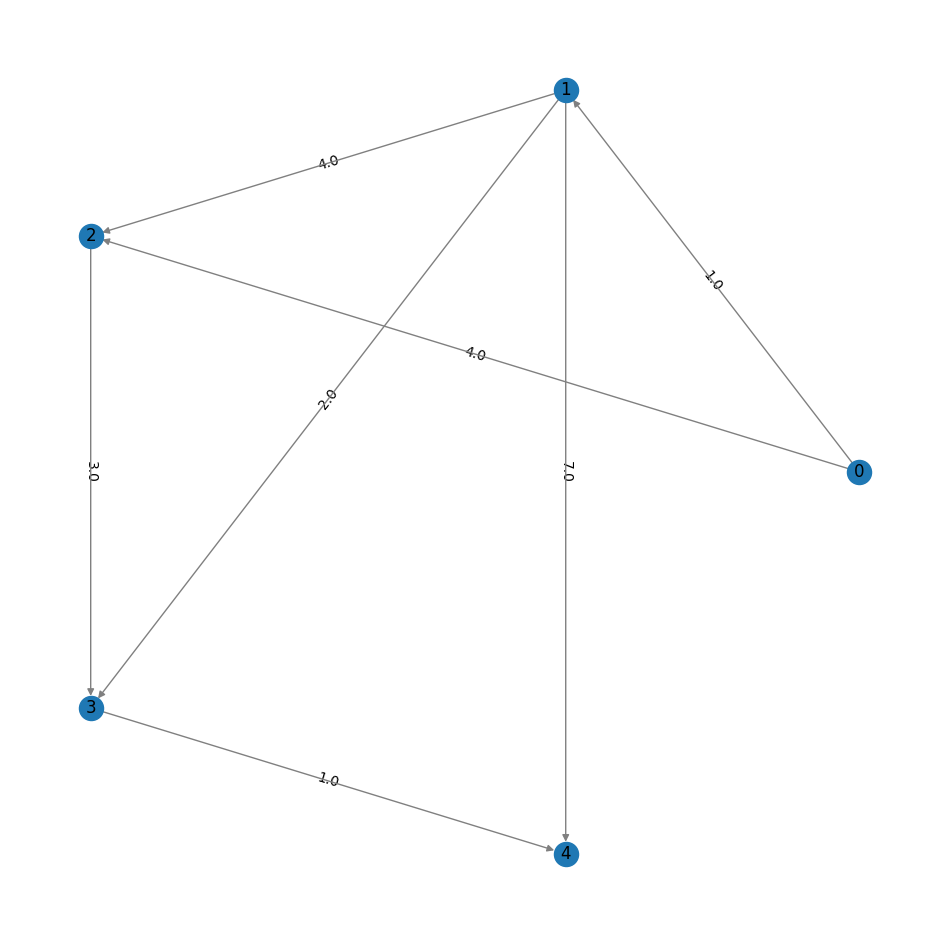

In [6]:
#utilitaires

weight_matrix = np.array([
    [0, 1, 4, np.inf, np.inf],
    [np.inf, 0, 4, 2, 7],
    [np.inf, np.inf, 0, 3, np.inf],
    [np.inf, np.inf, np.inf, 0, 1],
    [np.inf, np.inf, np.inf, np.inf, 0]
])


def ToAdj(W,loop=False):
    """
    Converts a weight matrix to the (most plausible) corresponding adjacency matrix
    
    :param W: Weight matrix 
    :type W: two dimensionnal numpy array
    :return: a adjacency matrix
    :rtype: two dimensionnal numpy array
    
    """
    A=np.copy(W)
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if W[i][j]==np.inf:
                A[i][j]=0
            else :
                if W[i][j]==0:
                    if i!=j:
                        A[i][j]=1
                        print("Warning: a weight is equal to 0")
                    else : 
                        if loop :
                            A[i][j]=1
                        else :
                            A[i][j]=0


                else :
                    A[i][j]=1

    return A

W = weight_matrix
A=ToAdj(W)
G=nx.from_numpy_array(A,create_using=nx.DiGraph())

edges = G.edges()



for u,v in G.edges():
    G[u][v]['weight'] = W[u][v]

# Visualization with edge weights
weights = nx.get_edge_attributes(G, 'weight')
pos=nx.circular_layout(G)

# Visualization with edge widths equal to edge weights
#width = [weights[e] for e in G.edges()]
nx.draw_networkx_edge_labels(G, pos, edge_labels = weights)
nx.draw(G, pos, edge_color = 'grey',with_labels=True)


>**_question_**<br>
_À la main_, mettre ce problème sous la forme matricielle pour l'optimisation linéaire

Le graphe correspondant à la matrice de pondération donnée est représenté ci-dessous, avec des arêtes orientées. La matrice de pondération est la suivante :

$$
\begin{bmatrix}
0 & 1 & 4 & \infty & \infty \\
\infty & 0 & 4 & 2 & 7 \\
\infty & \infty & 0 & 3 & \infty \\
\infty & \infty & \infty & 0 & 1 \\
\infty & \infty & \infty & \infty & 0
\end{bmatrix}
$$

>**_question_**<br>
Écrire un programme résolvant le problème des plus courts chemin via optimisation linéaire (on utilisera `linprog` de `scipy`)

In [7]:
def shortest_path_linprog(weight_matrix, source):
    num_nodes = weight_matrix.shape[0]
    
    # Variables de décision : distances d[i]
    # Nous devons minimiser la somme des distances depuis le sommet source
    
    # Coefficients de la fonction objectif : maximiser les distances -> minimiser -d
    c = np.zeros(num_nodes)
    c[source] = 1  # La distance de la source à elle-même est 0, donc on la fixe à 0
    
    # Contrainte d[s] = 0
    A_eq = np.zeros((1, num_nodes))
    A_eq[0, source] = 1
    b_eq = np.array([0])
    
    # Contrainte d[v] - d[u] <= w(u,v) pour chaque arête
    A_ub = []
    b_ub = []
    
    for u in range(num_nodes):
        for v in range(num_nodes):
            if weight_matrix[u, v] < np.inf and u != v:
                constraint = np.zeros(num_nodes)
                constraint[v] = 1
                constraint[u] = -1
                A_ub.append(constraint)
                b_ub.append(weight_matrix[u, v])
    
    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)
    
    # Appeler la fonction linprog
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None, None), method='highs')
    
    if result.success:
        return result.x
    else:
        return None


Les plus courts chemins à partir du sommet 0 : [-0.  1.  4.  3.  4.]


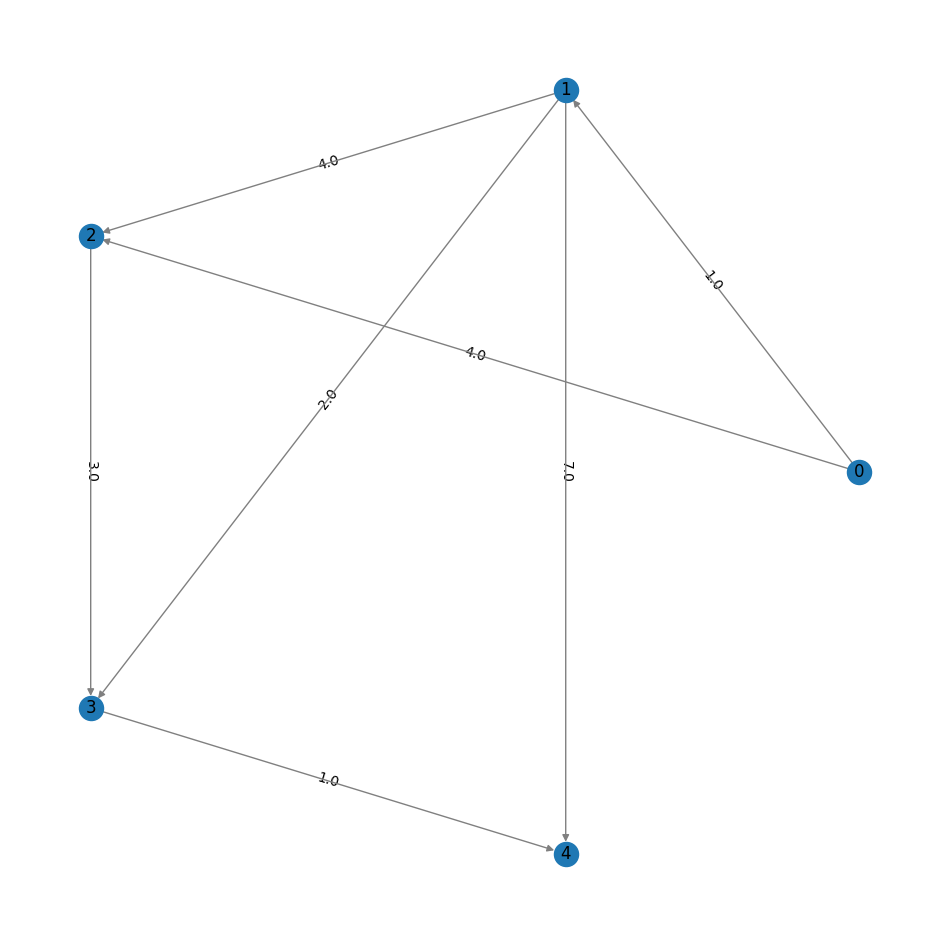

In [8]:
weight_matrix = np.array([
    [0, 1, 4, np.inf, np.inf],
    [np.inf, 0, 4, 2, 7],
    [np.inf, np.inf, 0, 3, np.inf],
    [np.inf, np.inf, np.inf, 0, 1],
    [np.inf, np.inf, np.inf, np.inf, 0]
])

source_vertex = 0
shortest_paths = shortest_path_linprog(weight_matrix, source_vertex)

A=ToAdj(W)
G=nx.from_numpy_array(A,create_using=nx.DiGraph())

edges = G.edges()



for u,v in G.edges():
    G[u][v]['weight'] = W[u][v]

# Visualization with edge weights
weights = nx.get_edge_attributes(G, 'weight')
pos=nx.circular_layout(G)

# Visualization with edge widths equal to edge weights
#width = [weights[e] for e in G.edges()]
nx.draw_networkx_edge_labels(G, pos, edge_labels = weights)
nx.draw(G, pos, edge_color = 'grey',with_labels=True)


print("Les plus courts chemins à partir du sommet", source_vertex, ":", shortest_paths)


# Régression linéaire

## Régression linéaire




Le but de cette partie est d'effectuer une **régression linéaire**, c'est-à-dire d'approcher nos données à l'aide d'une fonction affine. Elle s'inspire entre autre de [cette vidéo](https://www.youtube.com/watch?v=HgY4mpKsFFo)

On reprend l'exemple de l'an dernier,  un tableau de taille et poids pour 15 personnes.


**Données :** 

| Id        | Height (cm)           | Weight (kg)  |
| ------------- |:-------------:| -----:|
| 1     | 147 |  49 |
| 2    | 150      |   50 |
|3 | 153      |     51 |
| 4     | 155 |  52 |
| 5    | 158      |   54 |
|6 | 160      |     56 |
| 7     | 163 |  58 |
| 8    | 165      |   59 |
|9 | 168      |     60 |
| 10     | 170 |  62 |
| 11    | 173      |   63 |
|12 | 175      |     64 |
| 13     | 178 |  66 |
| 14    | 180      |   67 |
|15 | 183      |     68 |
|16 | 168      |     58 |


__On voudrait approcher les données au mieux à l'aide d'une droite $y = a . x + b$.__


On va (re)voir deux méthodes, qui diffèrent sur l'approche pratique (type d'optimisation) et théorique (choix du _au mieux_)

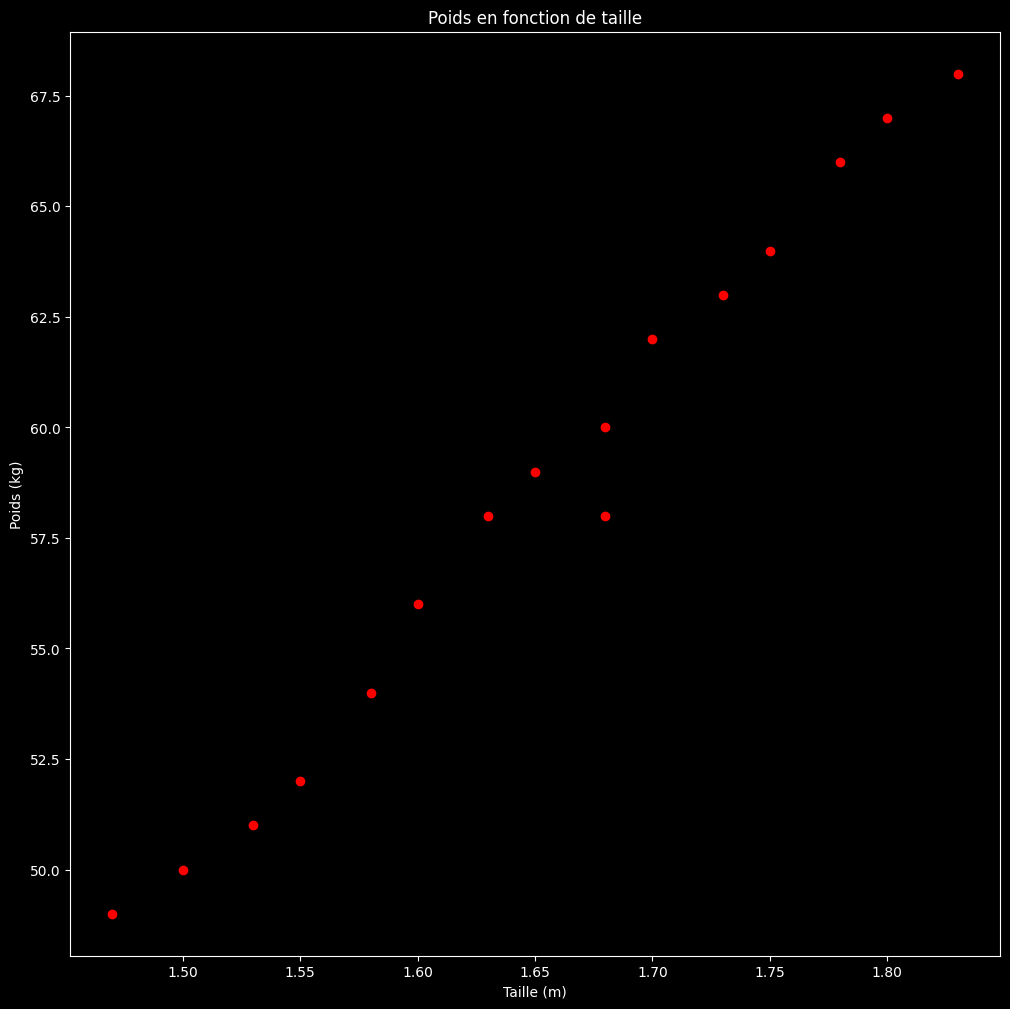

In [9]:
plt.close()

# data
#taille en mètres
x = np.array([1.47, 1.50, 1.53, 1.55, 1.58, 1.60, 1.63, 1.65, 1.68, 1.70, 1.73, 1.75, 1.78, 1.80, 1.83,1.68]) #Taille
y = np.array([49.,50.,51.,52.,54.,56.,58.,59.,60.,62.,63.,64.,66.,67.,68.,58]) #Poids

#print(X.shape)
#print(y.shape)


# plot the data
plt.scatter(x,y, color='red')
plt.title('Poids en fonction de taille')
plt.xlabel('Taille (m)')
plt.ylabel('Poids (kg)')

plt.show()


In [10]:
def plotDroite(dataX,dataY,a,b):
    
    # Representation des donnees x en fct de y
    plt.scatter(dataX,dataY, color='red')
    plt.title('Poids en fonction de taille')
    plt.xlabel('Taille (en m)')
    plt.ylabel('Poids')
    
    #Representation de la droite y=ax+b
    xinf=np.linspace(min(x)-10,max(x)+10,500)
    yinf=[a*i+b for i in xinf]
    
    plt.plot(xinf,yinf, color='blue')
    plt.ylim(min(y)-5,max(y)+5)
    plt.xlim(min(x)-0.1,max(x)+0.1)
    
    plt.tight_layout()

    plt.show()

interact(plotDroite, dataX=fixed(x),dataY=fixed(y),a=(-80, 80, 0.5), b=(-50, 50, .1))


interactive(children=(FloatSlider(value=0.0, description='a', max=80.0, min=-80.0, step=0.5), FloatSlider(valu…

<function __main__.plotDroite(dataX, dataY, a, b)>

## Moindre carrés (norme $L_2$)
C'est la méthode qu'on a vu l'an dernier en R4.04.

Ici la fonction à minimiser est la fonction $E(a,b) = \sum_i(y_ i - (aX_i + b))^2$.


Les paramètres optimaux (que l'on obtient analytiquement par dérivation de $E(a,b)$ en résolvant $\nabla E(a,b) = [\frac{\partial E(a,b)}{\partial a},\frac{\partial E(a,b)}{\partial b}] = [0,0]$ ou par méthode du gradient) sont 


$$a^* = \frac{cov(x,y)}{var(x)}$$

$$b^*=\bar{y}-a^*\bar{x}$$

In [11]:
#paramètres optimaux L2 (fonctionne pour toute regression linéaire en dimension 1)

#homebrew covariance
def cov(x,y):
    return (sum([x[i]*y[i] for i in range(len(x))])/len(x)-np.mean(x)*np.mean(y))

def droite(a,b,x):
    return a*x+b

def E(a,b,x,y):
    return sum([(y[i]-(a*x[i]+b))**2 for i in range(len(x))])


#sinon, on peut utiliser la fonction de covariance de python : 
#covar = np.cov(taille,poids,bias=True)[0][1]

print('var = ',np.var(x))
print('covar = ',cov(x,y))

ast=cov(x,y)/np.var(x)
print('a* = ',ast)

bst=np.mean(y) - ast * np.mean(x)
print('b* = ',bst)


print("Erreur minimale (somme des écarts au carré):", round(E(ast, bst, x, y),2))


var =  0.0112109375
covar =  0.6285156249999915
a* =  56.062717770034084
b* =  -34.151219512193876
Erreur minimale (somme des écarts au carré): 8.16


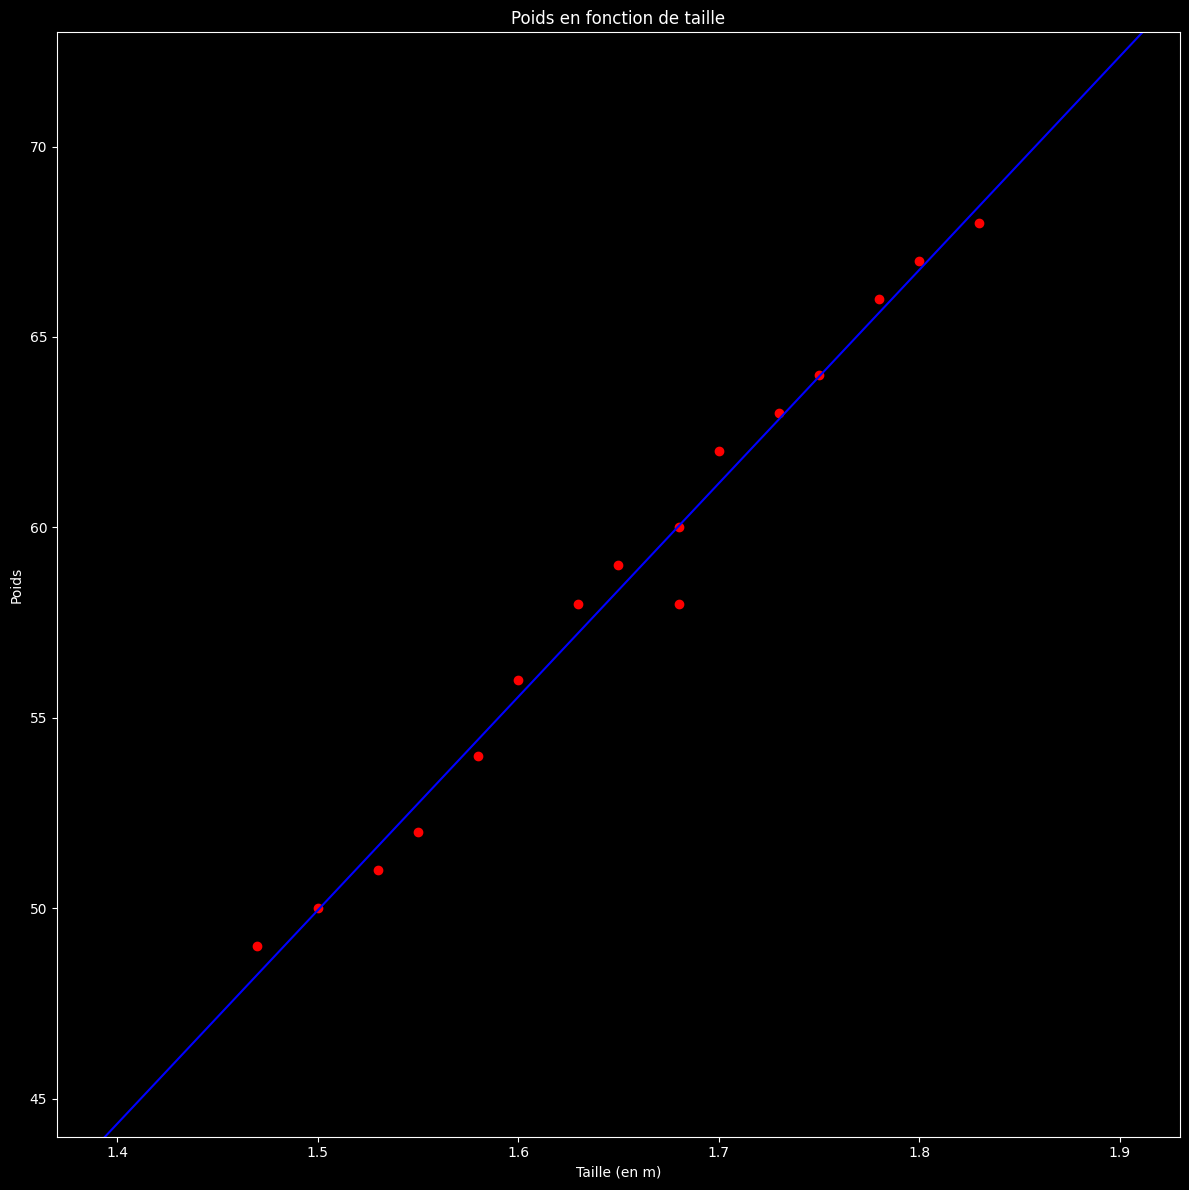

In [12]:
plotDroite(x,y,ast,bst)


## Moindre valeur absolue (norme $L_1$)

LA méthode des moindre carrés donne des résultats tout à fait pertinents et satisfaisant, cependant elle n'est pas la plus naturelle.

En effet, la fonction d'erreur qui vient en premier à l'esprit est $$E_1 (a,b) = \sum_i |y_ i - (aX_i + b)|$$.


En pratique, ce n'est pas elle que l'on choisit car la minimiser est plus difficile (théoriquement et en temps machine). Cependant on peut trouver _par programmation linéaire_ les paramètres optimaux pour ce problème, et comparer la droite ainsi obtenue à celle des moindre carrée.

Partons de 
$$E_1 (a,b) = \sum_i |y_ i - (aX_i + b)|$$

On écrit $e_i = |y_ i - (aX_i + b)|$, le problème devient alors


$\text{ Minimiser} \sum_i e_i $

sous contraintes 
$\begin{cases}e_i  = |y_ i - (aX_i + b)|\end{cases}$

<br>
<br>

Que l'on réécrit encore 

$\text{ Minimiser} \sum_i e_i $


sous contraintes 

$\begin{cases}e_i  &\leq y_ i - (aX_i + b)\\
e_i  &\geq - (y_ i - (aX_i + b))
\end{cases}$


soit

$\begin{cases}e_i  &\leq y_ i - (aX_i + b)\\
-e_i  &\leq (y_ i - (aX_i + b))
\end{cases}$

que l'on peut mettre en forme plus proche d'un problème linéaire 

sous contraintes 
$\text{ Maximiser} -\sum_i e_i $
sous contraintes 

$\begin{cases}
aX_i  + b   + e_i  &\leq y_ i)\\
-aX_i - b - e_i  &\leq -y_ i
\end{cases}$


>**_question_**<br>
Mettre ce problème sous la forme matricielle :

$\text{ Maximiser} $

$c_{lp} [a,b,e_1, ... e_n] $

Sous contraintes 
$
\begin{cases}
A_{lp} [a,b,e_1, ... e_n] &=b_{lp}\\
\end{cases}$


Nous voulons minimiser la somme des erreurs absolues $e_i$ avec les contraintes sur $a$ et $b$. Le problème peut se réécrire sous forme matricielle comme suit :

**Formulation matricielle :**

- **Vecteur coût** $c_{lp} = [0, 0, 1, 1, \dots, 1]$  
    - Les deux premières entrées correspondent à $a$ et $b$, donc elles sont nulles car nous ne voulons pas les minimiser directement.  
    - Les autres entrées correspondent aux $e_i$, qui sont les erreurs absolues que nous cherchons à minimiser.

- **Matrice des contraintes** $A_{lp}$ et vecteur des bornes $b_{lp}$ :
    - Pour chaque $i$, les deux contraintes sont :
    $$
    \begin{aligned}
    a X_i + b + e_i &\leq Y_i \\
    -a X_i - b + e_i &\leq -Y_i
    \end{aligned}
    $$
    - $A_{lp}$ contient les coefficients de $a$, $b$, et des $e_i$ pour chaque contrainte. Chaque ligne de $A_{lp}$ représente une contrainte. Par exemple, pour la première contrainte, les coefficients sont $X_i$, $1$ (pour $b$), et $1$ (pour $e_i$).
    - Le vecteur $b_{lp}$ contient les bornes de ces inégalités : soit $Y_i$ et $-Y_i$.

Ainsi, le problème se traduit sous la forme standard de la programmation linéaire :
$$
\text{Minimiser} \quad c_{lp} \cdot [a, b, e_1, \dots, e_n]
$$
Sous contraintes :
$$
A_{lp} \cdot [a, b, e_1, \dots, e_n] \leq b_{lp}
$$


In [13]:
def l1_regression_linprog_error(x, y):
    n = len(x)
    
    # Coefficients de la fonction objectif : minimiser la somme des e_i
    c_lp = np.zeros(2 + n)
    c_lp[2:] = 1  # les e_i (variables d'erreur)

    # Contraintes sous forme A_lp * [a, b, e_1, ..., e_n] <= b_lp
    A_lp = np.zeros((2 * n, 2 + n))  # Matrice de contraintes
    b_lp = np.zeros(2 * n)  # Partie droite des contraintes

    # Remplir la matrice de contraintes et les bornes
    for i in range(n):
        # a X_i + b + e_i <= Y_i
        A_lp[i, 0] = x[i]  # coefficient de a
        A_lp[i, 1] = 1      # coefficient de b
        A_lp[i, 2 + i] = 1  # coefficient de e_i
        b_lp[i] = y[i]      # côté droit

        # -a X_i - b + e_i <= -Y_i
        A_lp[n + i, 0] = -x[i]  # coefficient de a
        A_lp[n + i, 1] = -1      # coefficient de b
        A_lp[n + i, 2 + i] = 1   # coefficient de e_i
        b_lp[n + i] = -y[i]      # côté droit

    # Appel à linprog
    result = linprog(c_lp, A_ub=A_lp, b_ub=b_lp, method='highs')
    
    if result.success:
        a = result.x[0]
        b = result.x[1]
        return a, b
    else:
        print("linprog failed. Result:", result)
        return None
    
linsol=l1_regression_linprog_error(x,y)


linprog failed. Result:        message: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)
       success: False
        status: 2
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None


In [14]:
a,b = linsol.x[:2]

print(a,b)
plotDroite(x,y,a,b)


AttributeError: 'NoneType' object has no attribute 'x'

Tiens, ça ne semble pas marcher ?

Le problème vient des contraintes (implicites) sur $b$ : scicpy suppose par défaut que l'on souhaite que toutes lesc variables soient positives.
Cela peut se régler via l'option `bounds`

>_**question**_ régler ce problème via l'option `bounds`


a = 56.52173913043474, b = -34.78260869565211


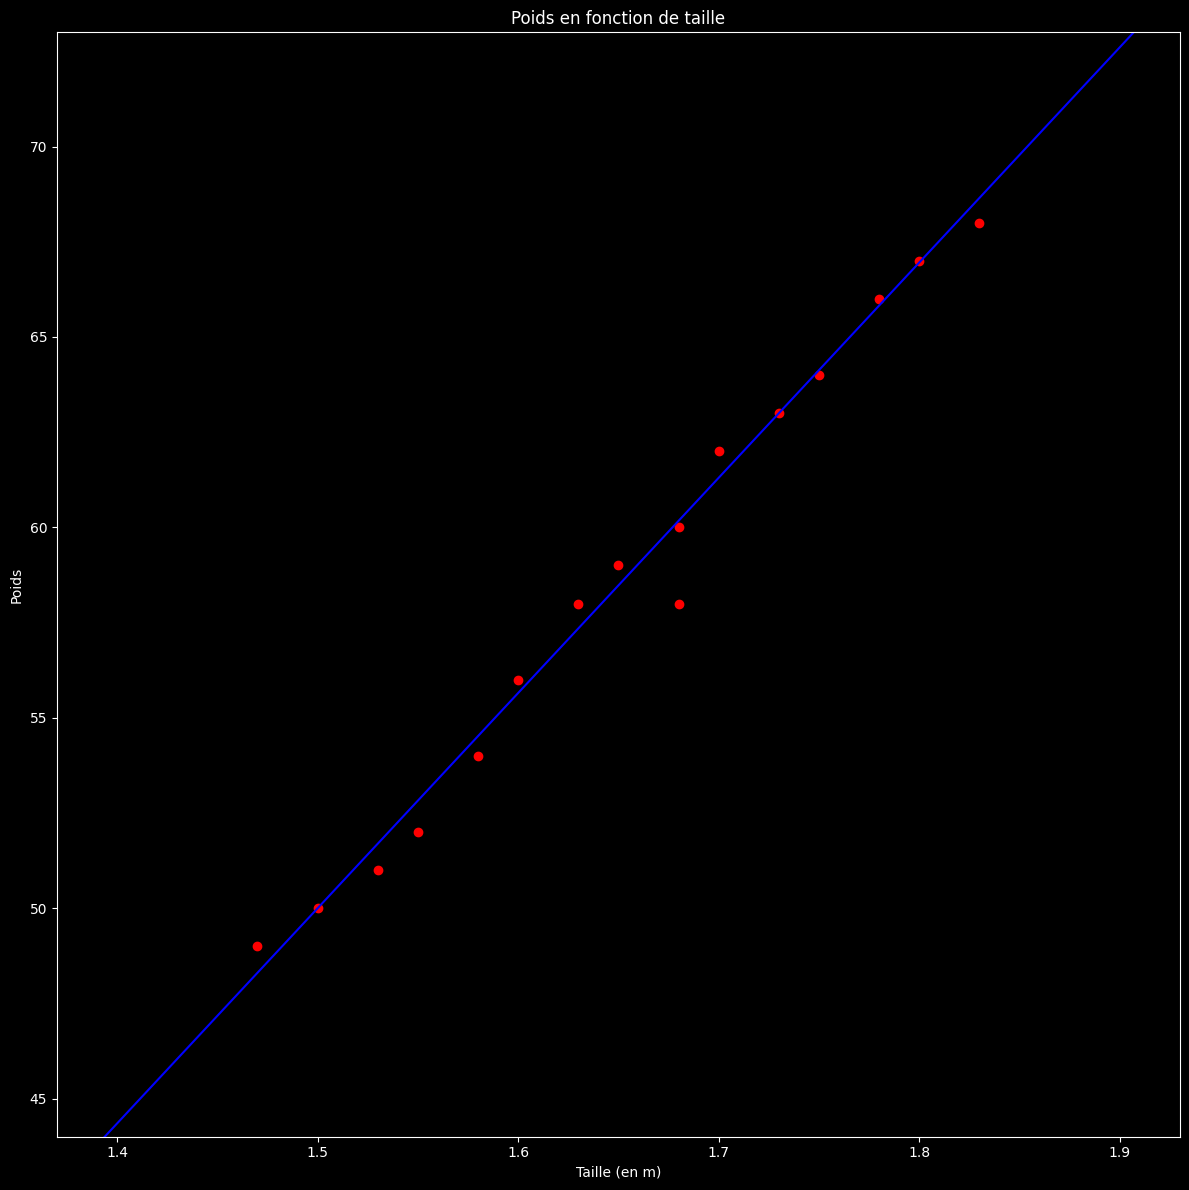

In [15]:
def l1_regression_linprog(x, y):
    n = len(x)
    
    # Coefficients de la fonction objectif : minimiser la somme des e_i
    c_lp = np.zeros(2 + n)
    c_lp[2:] = 1  # les e_i (variables d'erreur)

    # Contraintes sous forme A_lp * [a, b, e_1, ..., e_n] <= b_lp
    A_lp = np.zeros((2 * n, 2 + n))  # Matrice de contraintes
    b_lp = np.zeros(2 * n)  # Partie droite des contraintes

    # Remplir la matrice de contraintes et les bornes
    for i in range(n):
        # a X_i + b - e_i <= Y_i
        A_lp[i, 0] = x[i]    # coefficient de a
        A_lp[i, 1] = 1       # coefficient de b
        A_lp[i, 2 + i] = -1  # coefficient de e_i
        b_lp[i] = y[i]       # côté droit

        # -a X_i - b - e_i <= -Y_i
        A_lp[n + i, 0] = -x[i]   # coefficient de a
        A_lp[n + i, 1] = -1      # coefficient de b
        A_lp[n + i, 2 + i] = -1  # coefficient de e_i
        b_lp[n + i] = -y[i]      # côté droit

    # Ajout des bornes : a et b non bornés, e_i >= 0
    bounds = [(None, None)] * 2 + [(0, None)] * n  # Pas de bornes pour a et b, mais e_i >= 0

    # Appel à linprog AVEC BORNES
    result = linprog(c_lp, A_ub=A_lp, b_ub=b_lp, bounds=bounds, method='highs')

    # Vérifier le succès de la résolution
    if result.success:
        a = result.x[0]
        b = result.x[1]
        return a, b
    else:
        print("linprog failed. Result:", result)
        return None

# Calculer les paramètres de régression L1
linsol = l1_regression_linprog(x, y)

# Affichage des résultats
if linsol is not None:
    a, b = linsol  # Extraction des valeurs de a et b
    print(f"a = {a}, b = {b}")
    plotDroite(x, y, a, b)  # Tracer la droite de régression
else:
    print("Erreur dans la résolution du problème.")


### Pour aller plus loin :

Écrire une fonction qui trace simultanément les deux droites de regression.

À l'aide de wigdets, observer les effets des outliners sur les deux droites.

In [16]:
def l2_regression(x, y):
    """
    Calcule les coefficients a et b de la régression des moindres carrés (L2).
    """
    n = len(x)
    A = np.vstack([x, np.ones(n)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return a, b

def plot_regression_lines(x, y, a_l2, b_l2, a_l1, b_l1):
    """
    Trace les points de données et les deux droites de régression L2 et L1.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Données')
    
    x_vals = np.linspace(min(x), max(x), 100)
    y_l2 = a_l2 * x_vals + b_l2
    y_l1 = a_l1 * x_vals + b_l1
    
    plt.plot(x_vals, y_l2, color='red', label=f'Régression L2: y = {a_l2:.2f}x + {b_l2:.2f}')
    plt.plot(x_vals, y_l1, color='green', label=f'Régression L1: y = {a_l1:.2f}x + {b_l1:.2f}')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Comparaison des régressions L2 et L1')
    plt.legend()
    plt.grid(True)
    plt.show()

x_base = np.array([1, 2, 3, 4, 5])
y_base = np.array([2, 2.5, 3, 3.5, 4])

def interactive_regression(outlier1_x, outlier1_y, outlier2_x, outlier2_y):
    # Combinaison des données de base avec les outliers
    x = np.append(x_base, [outlier1_x, outlier2_x])
    y = np.append(y_base, [outlier1_y, outlier2_y])
    
    # Calcul des régressions L2 et L1
    a_l2, b_l2 = l2_regression(x, y)
    a_l1, b_l1 = l1_regression_linprog(x, y)
    
    if a_l1 is not None and b_l1 is not None:
        # Tracer les résultats
        plot_regression_lines(x, y, a_l2, b_l2, a_l1, b_l1)
    else:
        print("Erreur dans la résolution de la régression L1.")

# Création des sliders pour les positions x et y des outliers
outlier1_x_slider = FloatSlider(value=6, min=5, max=10, step=0.1, description='Outlier 1 x')
outlier1_y_slider = FloatSlider(value=8, min=5, max=15, step=0.1, description='Outlier 1 y')
outlier2_x_slider = FloatSlider(value=7, min=5, max=10, step=0.1, description='Outlier 2 x')
outlier2_y_slider = FloatSlider(value=1, min=-5, max=5, step=0.1, description='Outlier 2 y')

interact(interactive_regression,
         outlier1_x=outlier1_x_slider,
         outlier1_y=outlier1_y_slider,
         outlier2_x=outlier2_x_slider,
         outlier2_y=outlier2_y_slider)



interactive(children=(FloatSlider(value=6.0, description='Outlier 1 x', max=10.0, min=5.0), FloatSlider(value=…

<function __main__.interactive_regression(outlier1_x, outlier1_y, outlier2_x, outlier2_y)>

----------------------------------

## Flots
### rappels (de la semaine prochaine !)


$G = (S, A)$ est un graphe orienté avec  une fonction de _capacité_ $c : S\times S \to \mathbb{N}$ tel que

- $\forall (u, v) \in A$, $c(u, v) > 0$

- $\forall (u, v) \notin A$, $c(u, v) = 0$


Dans ce graphe on distingue 2 sommets particuliers
- $s$ : source ($d^- = 0$, pas d'arêtes entrantes)
- $t$ : puits ($d^+ = 0$, pas d'arêtes sortantes)

Sur un tel graphe, un _flot_ est  est une fonction $f : S^2 \to \mathbb{R}$ tq

- **Contraintes de capacité** : $f(u,v) \le c(u,v)$ (la quantité de flot sur un arc ne dépasse pas la capacité de cet arc)

- **Anti-symétrie** $f(u,v) = - f(v,u)$

- **Conservation du flot** $\sum_{w \in S} f(u,w) = 0$ , sauf si $u=s$ ou $u=t$ (sur chaque sommet sauf s et t, la somme des flots entrants est égale à la somme des flots sortants)

La _valeur_ totale du flot est $\sum_{(s,u) \in A} f(s, u) = \sum_{(v,t) \in A} f(v, t)$


Voici un exemple de graphe orienté avec capacité (la source et le puits sont en vert). L'illustration a été réalisée en utilisant la bibliothèque `networkx`:

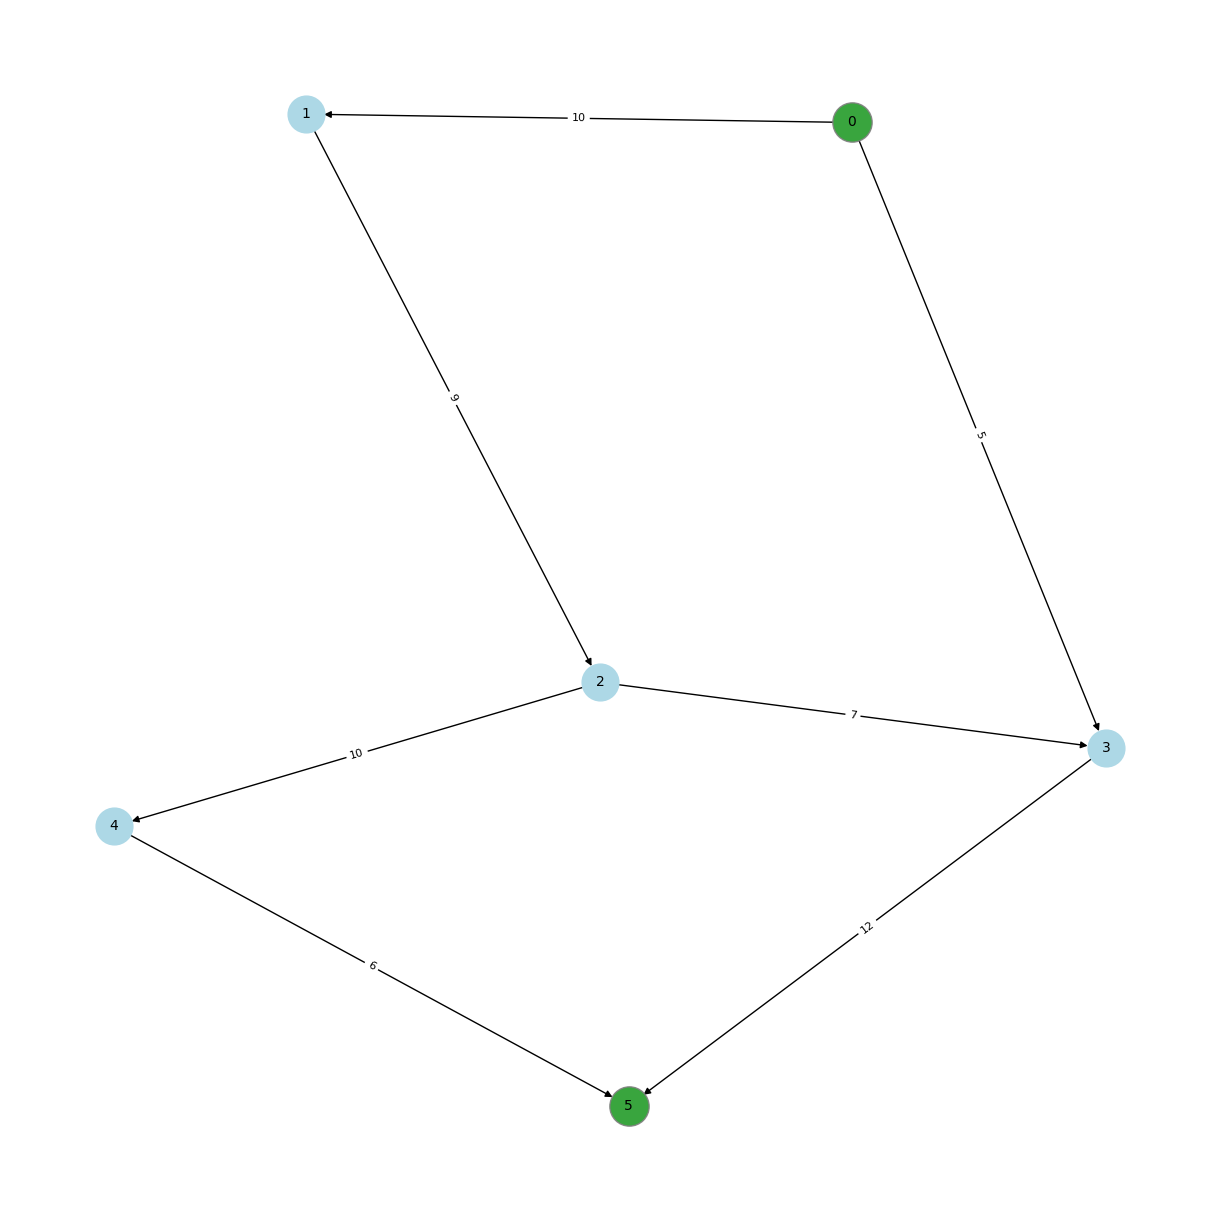

In [21]:
capacity_matrix = np.array([
    [0, 10, 0, 5, 0, 0],
    [0, 0, 9, 0, 0, 0],
    [0, 0, 0, 7, 10, 0],
    [0, 0, 0, 0, 0, 12],
    [0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0]
])

source = 0
puits = 5

# Create a directed graph from the capacity matrix
G = nx.DiGraph()
for i in range(len(capacity_matrix)):
    for j in range(len(capacity_matrix[0])):
        if capacity_matrix[i][j] > 0:
            G.add_edge(i, j, capacity=capacity_matrix[i][j])
            
for u, v, data in G.edges(data=True):
    capacity = data['capacity']
    
# Draw the graph with edge labels
pos = nx.spring_layout(G)
labels = {edge: f"{G.edges[edge]['capacity']}" for edge in G.edges}
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black')
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[source, puits], node_color="tab:green", **options)
#nx.draw_networkx_edges(G, pos, edge_color='edge_colors', width=3, edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.show()


# Flot : contraintes linéaires

La formulation

>- **Contraintes de capacité** : $f(u,v) \le c(u,v)$ (la quantité de flot sur un arc ne dépasse pas la capacité >de cet arc)
>
>- **Anti-symétrie** $f(u,v) = - f(v,u)$
>
>- **Conservation du flot** $\sum_{w \in S} f(u,w) = 0$ , sauf si $u=s$ ou $u=t$ (sur chaque sommet sauf s et t, >la somme des flots entrants est égale à la somme des flots sortants)

>La _valeur_ totale du flot est $\sum_{(s,u) \in A} f(s, u) = \sum_{(v,t) \in A} f(v, t)$

ressemble fortement à un problème d'optimisation linéaire. On peut le reformuler comme :


**Maximiser**  $\sum_{(s,u) \in A} f(s, u)$

**sous les contraintes**

$f(u,v) \le c(u,v), \quad \forall (u,v) \in A$
$f(u,v) \ge 0, \quad \forall (u,v) \in A$
$\sum_{x \text{ voisin sortant de } u } f(u,x) - \sum_{y \text{ voisin entrant de } u} f(y, u) = 0$
$\sum_{w \in S} f(u,w) = 0$ 



Les variables sont donc les valeurs du flow sur chaque arête.

On va construire :

- une matrice $A_{cons}$ qui garantira la conservation du flot
- un vecteur $b_{cons}$, égal à $0$ sur toutes ses coordonnées
- une matrice $A_{capa}$, égale à la matrice identité
- un vecteur $b_{capa}$ qui contiendra les capacités de chaque arête
- un vecteur de coût $c$ qui vaut $1$ sur les arêtes sortant de $s$



plus précisément la matrice $A_{cons}$ sera une matrice a (nombre de sommets -2 [la source et le puits]) lignes et (nombre d'arêtes) colonnes (il s'agit en fait de la matrice d'incidence où l'on a retiré les lignes de la source et du puits)


>**_question_**<br>
Écrire les matrices et vecteurs correspondant au problème d'optimisation linéaire associé à un graphe de capacité $G$ (donné comme une matrice de capacité).<br>


$
\text{Maximiser } c^T . f \\ \text{ sous contraintes }
\begin{cases}
A_{cons} . f &= b_{cons} \\ 
A_{capa} . f &\leq b_{capa}
\end{cases}$




In [22]:
#https://cs.au.dk/~gerth/ipsa18/slides/linear_programming.pdf

def toIncidence(M):
    n = M.shape[0]  # Number of nodes
    m = np.count_nonzero(M)  # Number of edges
    I = np.zeros((n, m), dtype=int)
    capa = np.zeros(m)
    edges = []
    cpt = 0
    for i in range(n):
        for j in range(n):
            if M[i, j] != 0:
                I[i, cpt] = -1  # From node i
                I[j, cpt] = 1   # To node j
                capa[cpt] = M[i, j]
                edges.append((i, j))
                cpt += 1
    return I, capa, edges

def build_flow_conservation_constraints(I, s, t):
    n, m = I.shape
    nodes = list(range(n))
    nodes.remove(s)
    nodes.remove(t)
    Acons = I[nodes, :]  # Incidence matrix without source and sink rows
    bcons = np.zeros(len(nodes))
    return Acons, bcons


def build_capacity_constraints(capa):
    m = len(capa)
    Acapa = np.eye(m)  # Identity matrix
    bcapa = capa       # Capacities
    return Acapa, bcapa

def build_objective_function(edges, s):
    m = len(edges)
    c = np.zeros(m)
    for idx, (u, v) in enumerate(edges):
        if u == s:
            c[idx] = -1  # Negative sign for maximization in minimization solver
    return c


def build_variable_bounds(capa):
    bounds = [(0, c) for c in capa]
    return bounds



def linearFlow(M, s, t):
    I, capa, edges = toIncidence(M)
    n, m = I.shape

    # Build flow conservation constraints
    nodes = list(range(n))
    nodes.remove(s)
    nodes.remove(t)
    Acons = I[nodes, :]  # Incidence matrix without source and sink rows
    bcons = np.zeros(len(nodes))

    # Build capacity constraints
    Acapa = np.eye(m)
    bcapa = capa

    # Build variable bounds
    bounds = [(0, c) for c in capa]

    # Build objective function
    c_obj = np.zeros(m)
    for idx, (u, v) in enumerate(edges):
        if u == s:
            c_obj[idx] = -1  # Negative for maximization

    # Solve the linear program
    result = linprog(c=c_obj, A_eq=Acons, b_eq=bcons, bounds=bounds, method='highs')

    if result.success:
        max_flow = -result.fun  # Negate to get the maximized value
        flow_values = result.x
        print(f"Maximum flow from node {s} to node {t}: {max_flow}")
        print("Flow values on edges:")
        for idx, (u, v) in enumerate(edges):
            print(f"Edge ({u} -> {v}): {flow_values[idx]}")
        return max_flow, flow_values, edges
    else:
        print("Linear programming problem could not be solved.")
        return None, None, None


capacity_matrix = np.array([
    [0, 10, 0, 5, 0, 0],
    [0, 0, 9, 0, 0, 0],
    [0, 0, 0, 7, 10, 0],
    [0, 0, 0, 0, 0, 12],
    [0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0]
])

source = 0
sink = 5

max_flow, flow_values, edges = linearFlow(capacity_matrix, source, sink)


Maximum flow from node 0 to node 5: 14.0
Flow values on edges:
Edge (0 -> 1): 9.0
Edge (0 -> 3): 5.0
Edge (1 -> 2): 9.0
Edge (2 -> 3): 3.0
Edge (2 -> 4): 6.0
Edge (3 -> 5): 8.0
Edge (4 -> 5): 6.0


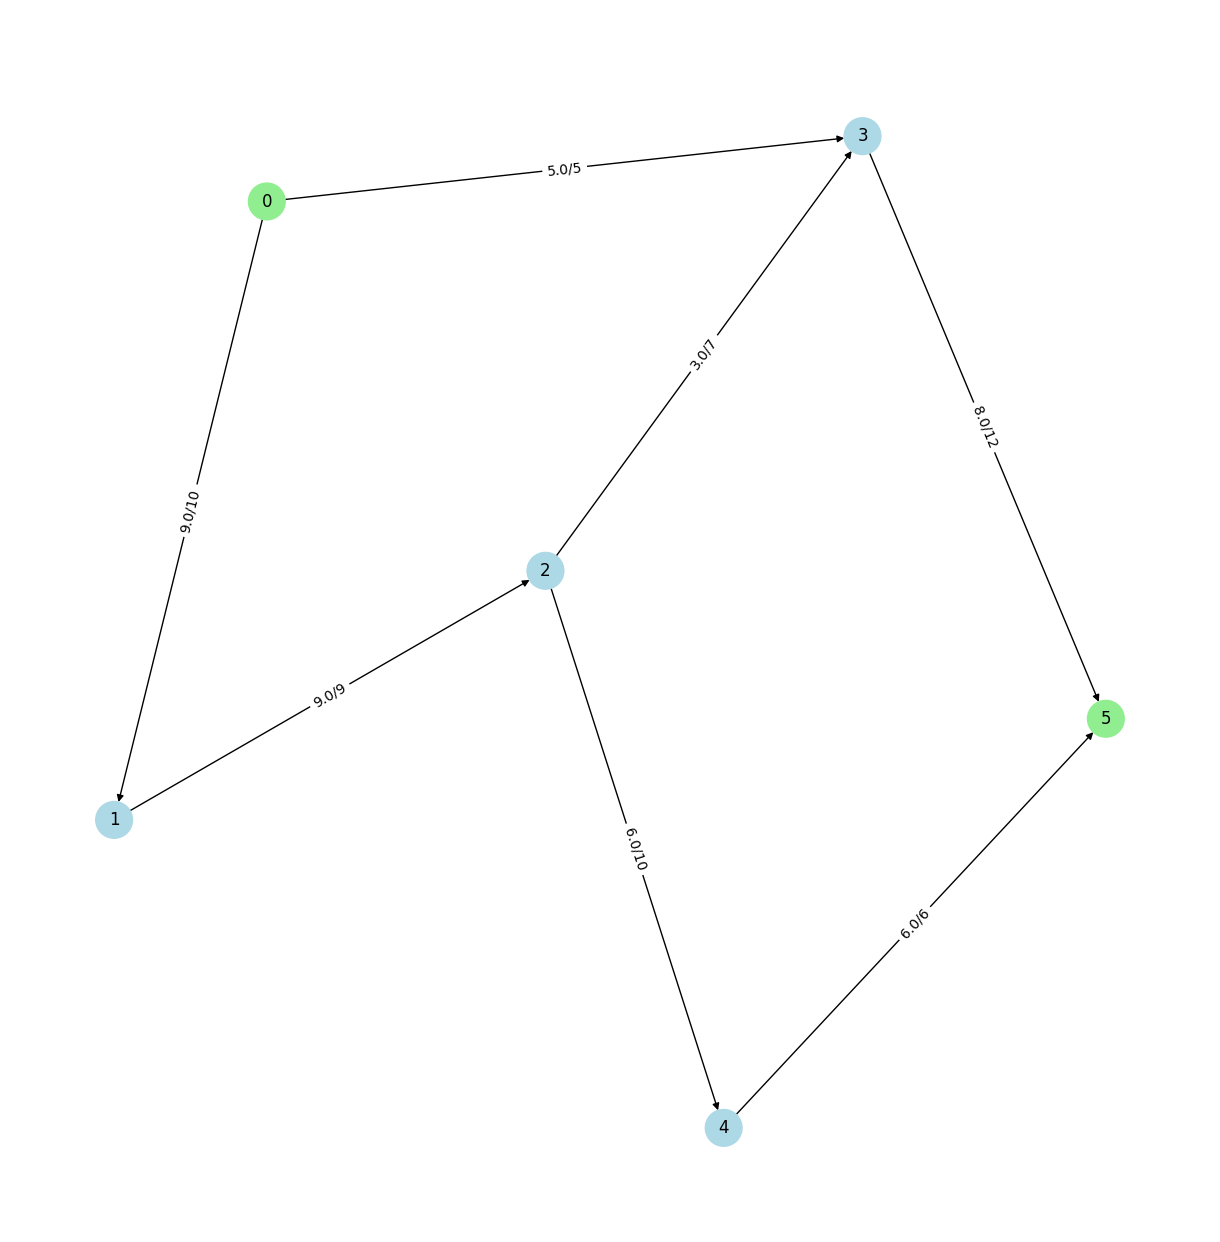

In [26]:
def draw_flow_graph(M, flow_values, edges, s, t):
    G = nx.DiGraph()
    n = M.shape[0]
    for idx, (u, v) in enumerate(edges):
        G.add_edge(u, v, capacity=M[u, v], flow=flow_values[idx])

    pos = nx.spring_layout(G)
    edge_labels = {(u, v): f"{G.edges[u, v]['flow']}/{G.edges[u, v]['capacity']}" for u, v in G.edges}
    node_colors = ['lightgreen' if node in [s, t] else 'lightblue' for node in G.nodes]

    nx.draw(G, pos, with_labels=True, node_size=700, node_color=node_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Flow Network with Capacities and Flows")
    plt.show()

draw_flow_graph(capacity_matrix, flow_values, edges, source, sink)






>_**question**_ <br> En utilisant Scipy, retrouvez les résultats du TP de modélisation. Les illustrer et les comparer au résultat trouvés en modélisation. 



In [27]:
Acons, bcons, Acapa, bcapa, c  = linearFlow(capacity_matrix)



TypeError: linearFlow() missing 2 required positional arguments: 's' and 't'